## Real Options Analysis for Petroleum E&P Project
#### Binomial Lattice Model for Exploration & Development

We implements a **Binomial Lattice Model** to value managerial flexibility in Oil & Gas projects. It compares traditional Net Present Value (NPV) against Real Options Value (ROV).

#### Key Features
- **American Option Logic:** Ability to invest at any time before lease expiration.
- **Geological Risk:** Adjusts value based on Probability of Success (Pg).


#### Methodology
We use the **Cox-Ross-Rubinstein (CRR)** binomial model. The underlying asset (Project Value) follows a Geometric Brownian Motion (GBM):

$$ dS = (r - \delta)S dt + \sigma S dZ $$

Where:
- $r$: Risk-free rate
- $\delta$: Convenience yield (cash flow lost by waiting)
- $\sigma$: Volatility of oil prices/reserves


####  Conclusion

1. **Negative NPV ≠ Reject:** If the option value is positive, the project holds strategic value (e.g., the right to wait for better prices).
2. **Volatility is Value:** Higher oil price volatility increases the value of the option to defer.
3. **Geological Risk:** Low success probability reduces value linearly, but does not eliminate the option premium.


In [13]:
# %load_ext autoreload
# %autoreload 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import logging
from dataclasses import dataclass, field
from typing import Optional, Dict, Any
from datetime import datetime
from IPython.display import display, HTML, Markdown

# Interactive Widgets
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, HBox, VBox

# Plotting Configuration
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12
%matplotlib inline

# Logging Configuration for Notebook
logging.basicConfig(
    level=logging.INFO,
    format='%(levelname)s: %(message)s'
)
logger = logging.getLogger(__name__)

In [14]:
@dataclass
class OptionParameters:
    """Container for Real Option model parameters."""
    spot_value: float
    strike_price: float
    time_to_maturity: float
    volatility: float
    risk_free_rate: float
    dividend_yield: float
    steps: int = 100
    success_probability: float = 1.0

    def __post_init__(self):
        self.validate()

    def validate(self):
        if self.spot_value <= 0: raise ValueError("Spot value must be positive.")
        if self.strike_price <= 0: raise ValueError("Strike price must be positive.")
        if self.volatility < 0: raise ValueError("Volatility cannot be negative.")
        if not 0 <= self.success_probability <= 1:
            raise ValueError("Success probability must be between 0 and 1.")

@dataclass
class ModelResults:
    """Container for model output and metrics."""
    option_value: float
    static_npv: float
    option_premium: float
    parameters: OptionParameters
    lattice_option: np.ndarray
    lattice_asset: np.ndarray
    timestamp: str = field(default_factory=lambda: datetime.now().isoformat())

class BinomialLatticeModel:
    """American Option Binomial Lattice Model for Petroleum Assets."""

    def __init__(self, params: OptionParameters):
        self.params = params
        self.dt = params.time_to_maturity / params.steps
        self.u = np.exp(params.volatility * np.sqrt(self.dt))
        self.d = 1 / self.u
        self.p = (np.exp((params.risk_free_rate - params.dividend_yield) * self.dt) - self.d) / (self.u - self.d)
        self.df = np.exp(-params.risk_free_rate * self.dt)

    def _build_asset_lattice(self) -> np.ndarray:
        S = np.zeros((self.params.steps + 1, self.params.steps + 1))
        for i in range(self.params.steps + 1):
            for j in range(i + 1):
                S[j, i] = self.params.spot_value * (self.u ** (i - j)) * (self.d ** j)
        return S

    def _backward_induction(self, S_tree: np.ndarray) -> np.ndarray:
        V = np.zeros_like(S_tree)
        V[:, -1] = np.maximum(S_tree[:, -1] - self.params.strike_price, 0)
        for i in range(self.params.steps - 1, -1, -1):
            for j in range(i + 1):
                hold = self.df * (self.p * V[j, i+1] + (1 - self.p) * V[j+1, i+1])
                exercise = S_tree[j, i] - self.params.strike_price
                V[j, i] = np.maximum(hold, np.maximum(exercise, 0))
        return V

    def calculate(self) -> ModelResults:
        S_tree = self._build_asset_lattice()
        V_tree = self._backward_induction(S_tree)
        
        unrisked_value = V_tree[0, 0]
        risked_value = unrisked_value * self.params.success_probability
        static_npv = (self.params.spot_value * self.params.success_probability) - self.params.strike_price
        
        return ModelResults(
            option_value=risked_value,
            static_npv=static_npv,
            option_premium=risked_value - max(static_npv, 0),
            parameters=self.params,
            lattice_option=V_tree,
            lattice_asset=S_tree
        )

In [15]:
def display_results_table(results: ModelResults):
    """Displays results as a nice HTML table."""
    data = {
        'Metric': ['Underlying Asset (S0)', 'Investment Cost (K)', 'Traditional NPV', 
                   'Real Options Value (ROV)', 'Option Premium', 'Geological Success (Pg)'],
        'Value': [
            f"${results.parameters.spot_value:.2f}M",
            f"${results.parameters.strike_price:.2f}M",
            f"${results.static_npv:.2f}M",
            f"${results.option_value:.2f}M",
            f"${results.option_premium:.2f}M",
            f"{results.parameters.success_probability*100:.1f}%"
        ]
    }
    df = pd.DataFrame(data)
    display(HTML(df.to_html(index=False, classes='table table-striped', border=0)))

def plot_lattice_heatmap(results: ModelResults):
    """Plots the option value lattice."""
    fig, ax = plt.subplots(figsize=(10, 8))
    mask = np.triu(np.ones_like(results.lattice_option, dtype=bool), k=1)
    
    cmap = sns.diverging_palette(240, 10, as_cmap=True)
    sns.heatmap(results.lattice_option, mask=mask, cmap=cmap, ax=ax, cbar_kws={'label': 'Value ($M)'})
    
    ax.set_title(f"Option Value Lattice (ROV = ${results.option_value:.2f}M)", fontsize=14)
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("State (Down Moves)")
    plt.show()

def plot_sensitivity_volatility(params: OptionParameters):
    """Plots ROV vs Volatility."""
    vols = np.linspace(0.05, 0.80, 50)
    rovs = []
    npvs = []
    
    for v in vols:
        p = OptionParameters(
            spot_value=params.spot_value, strike_price=params.strike_price,
            time_to_maturity=params.time_to_maturity, volatility=v,
            risk_free_rate=params.risk_free_rate, dividend_yield=params.dividend_yield,
            steps=50, success_probability=params.success_probability
        )
        m = BinomialLatticeModel(p)
        r = m.calculate()
        rovs.append(r.option_value)
        npvs.append(r.static_npv)
        
    plt.figure(figsize=(10, 6))
    plt.plot(vols, rovs, label='Real Options Value', color='green', linewidth=2)
    plt.axhline(y=max(params.spot_value * params.success_probability - params.strike_price, 0), 
                color='red', linestyle='--', label='Static NPV')
    plt.xlabel('Volatility (σ)')
    plt.ylabel('Value ($ Million)')
    plt.title('Sensitivity of Option Value to Volatility')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

### Base Case Valuation Results

Metric,Value
Underlying Asset (S0),$150.00M
Investment Cost (K),$160.00M
Traditional NPV,$-70.00M
Real Options Value (ROV),$17.17M
Option Premium,$17.17M
Geological Success (Pg),60.0%


**Insight:** Project is negative on NPV but positive on Real Options. **Do not abandon; wait.**

-------------------------------------------------------------------

### Option Value Lattice

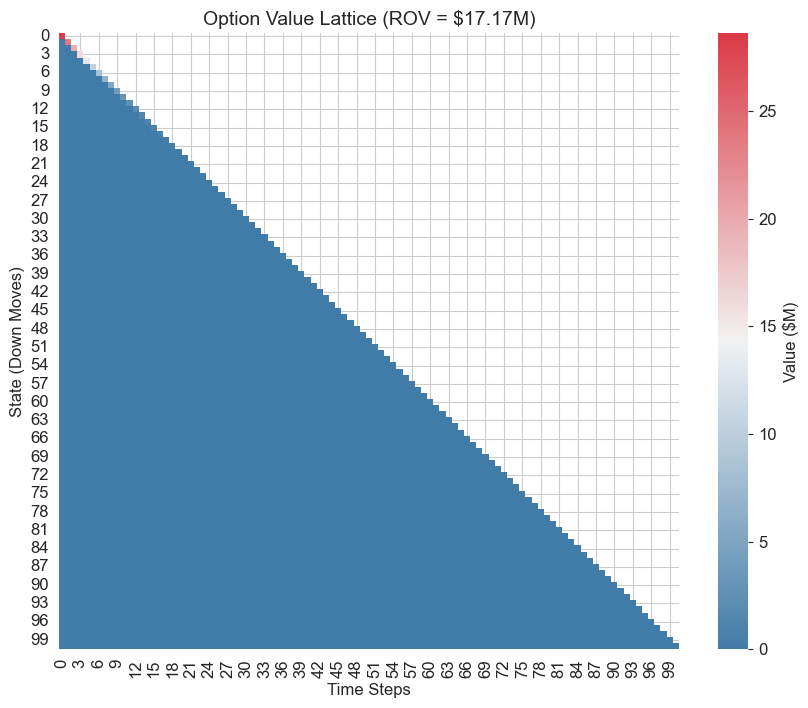

In [16]:
# Define Base Case Parameters
base_params = OptionParameters(
    spot_value=150.0,          # PV of Reserves ($M)
    strike_price=160.0,        # CAPEX ($M)
    time_to_maturity=5.0,      # Years
    volatility=0.30,           # 30%
    risk_free_rate=0.04,       # 4%
    dividend_yield=0.05,       # 5% (Convenience Yield)
    steps=100,
    success_probability=0.60   # 60%
)

# Run Model
model = BinomialLatticeModel(base_params)
results = model.calculate()

# Display Outputs
display(Markdown("### Base Case Valuation Results"))
display_results_table(results)

if results.static_npv < 0 and results.option_value > 0:
    display(Markdown("**Insight:** Project is negative on NPV but positive on Real Options. **Do not abandon; wait.**"))
elif results.option_value > results.static_npv:
    display(Markdown("**Insight:** Flexibility adds value. **Defer investment** if possible."))
else:
    display(Markdown("** Insight:** Invest **Immediately**."))

# Plot Lattice
display(Markdown("-------------------------------------------------------------------"))
display(Markdown("### Option Value Lattice"))
plot_lattice_heatmap(results)

### Function wrapped by widgets for interactive analysis

In [17]:
def interactive_analysis(spot, cost, vol, success_prob):

    try:
        params = OptionParameters(
            spot_value=spot,
            strike_price=cost,
            time_to_maturity=5.0,
            volatility=vol,
            risk_free_rate=0.04,
            dividend_yield=0.05,
            steps=50,
            success_probability=success_prob
        )
        model = BinomialLatticeModel(params)
        res = model.calculate()
        
        # Update Text Output
        output_text = f"""
        🔄 Calculation
        
        - Traditional NPV: ${res.static_npv:.2f} Million
        - Real Options Value: ${res.option_value:.2f} Million
        - Option Premium: ${res.option_premium:.2f} Million
        
        Decision:
        """
        if res.static_npv < 0 and res.option_value > 0:
            output_text += "🟢 **WAIT** (Value in Flexibility)"
        elif res.option_value > res.static_npv:
            output_text += "🟡 **DEFER** (Monitor Prices)"
        else:
            output_text += "🔴 **INVEST NOW**"
            
        display(Markdown(output_text))
        
        # Update Plot
        plt.figure(figsize=(8, 5))
        plt.plot([0, 1], [res.static_npv, res.static_npv], 'r--', label='NPV')
        plt.bar(['NPV', 'ROV'], [max(res.static_npv, 0), res.option_value], color=['red', 'green'])
        plt.ylabel('Value ($M)')
        plt.title('NPV vs Real Options Value')
        plt.ylim(0, max(res.option_value, res.static_npv) * 1.5)
        plt.legend()
        plt.show()
        
    except Exception as e:
        display(Markdown(f"**Error:** {str(e)}"))

# Create Widgets
w_spot = widgets.FloatSlider(value=150, min=50, max=300, step=10, description='Asset Value (S0):')
w_cost = widgets.FloatSlider(value=160, min=50, max=300, step=10, description='CAPEX (K):')
w_vol = widgets.FloatSlider(value=0.30, min=0.05, max=0.80, step=0.05, description='Volatility:')
w_pg = widgets.FloatSlider(value=0.60, min=0.1, max=1.0, step=0.1, description='Success Prob:')

# Display Interactive Dashboard
display(Markdown("### Interactive Sensitivity Dashboard"))
display(Markdown("Adjust sliders to see how parameters impact the investment decision."))
interact(interactive_analysis, spot=w_spot, cost=w_cost, vol=w_vol, success_prob=w_pg);

### Interactive Sensitivity Dashboard

Adjust sliders to see how parameters impact the investment decision.

interactive(children=(FloatSlider(value=150.0, description='Asset Value (S0):', max=300.0, min=50.0, step=10.0…

#### Volatility Sensitivity Analysis

In Real Options, higher uncertainty increases value (unlike NPV).

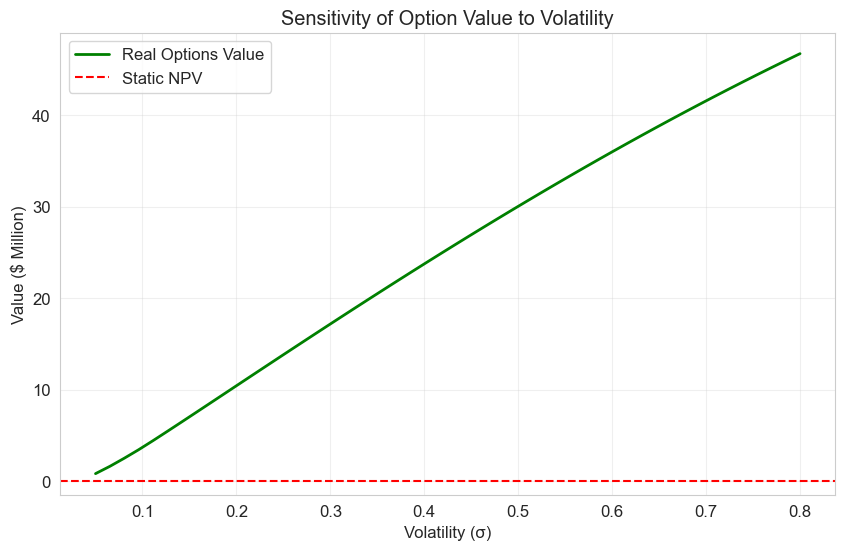

In [12]:
display(Markdown("#### Volatility Sensitivity Analysis"))
display(Markdown("In Real Options, higher uncertainty increases value (unlike NPV)."))
plot_sensitivity_volatility(base_params)